# **Natural Language Processing with Disaster Tweets**

Goal for this project is to predict which Tweets are about real disasters and which ones are not. Kaggle competition's dataset will be used and my model will be started from the theory that the words contained in each tweet are a good indicator of whether they're about a real disaster or not.

## 1) Look at the datasets

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from nltk.corpus import stopwords 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [42]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [43]:
train_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [44]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


5 Tweets which **are not** about disasters :

In [45]:
train_df[train_df["target"] == 0]["text"].values[0:5]

array(["What's up man?", 'I love fruits', 'Summer is lovely',
       'My car is so fast', 'What a goooooooaaaaaal!!!!!!'], dtype=object)

5 Tweets which **are** about disasters :

In [46]:
train_df[train_df["target"] == 1]["text"].values[0:5]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
      dtype=object)

## 1-1) Missing values

Text(0.5, 1.0, 'Test Set')

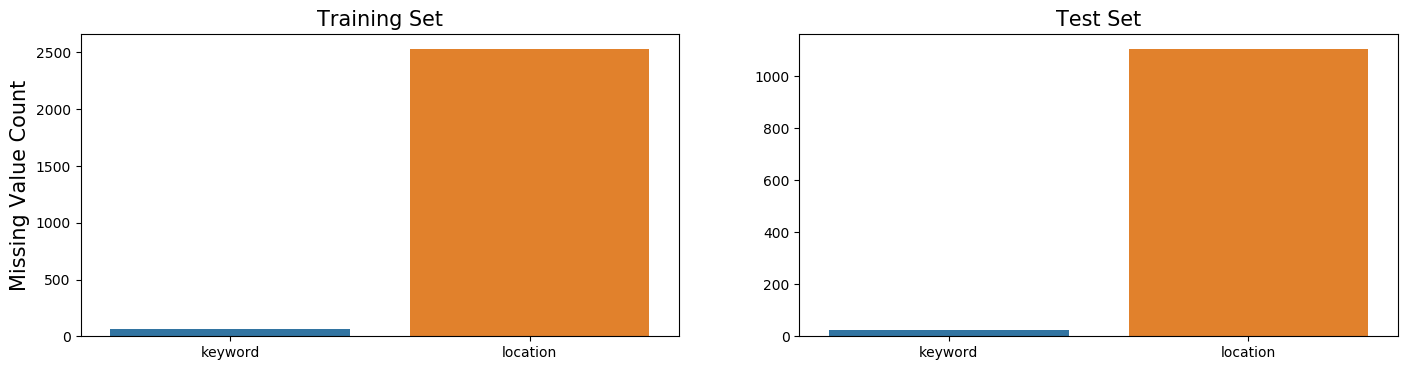

In [47]:
cols = ['keyword', 'location']
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=train_df[cols].isnull().sum().index, 
            y=train_df[cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test_df[cols].isnull().sum().index, 
            y=test_df[cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count',size=15)
axes[0].set_title('Training Set', fontsize=15)
axes[1].set_title('Test Set', fontsize=15)

## 1-2) Target Distribution and Cardinality

Text(0, 0.5, 'Tweets')

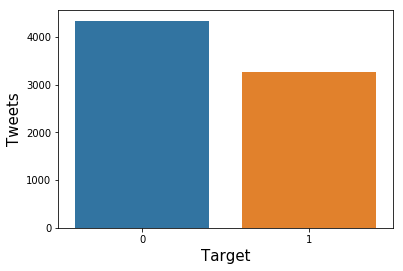

In [48]:
x = train_df.target.value_counts()
target_distribution = sns.barplot(x.index, x)
target_distribution.set_xlabel('Target', size=15)
target_distribution.set_ylabel('Tweets', size=15)

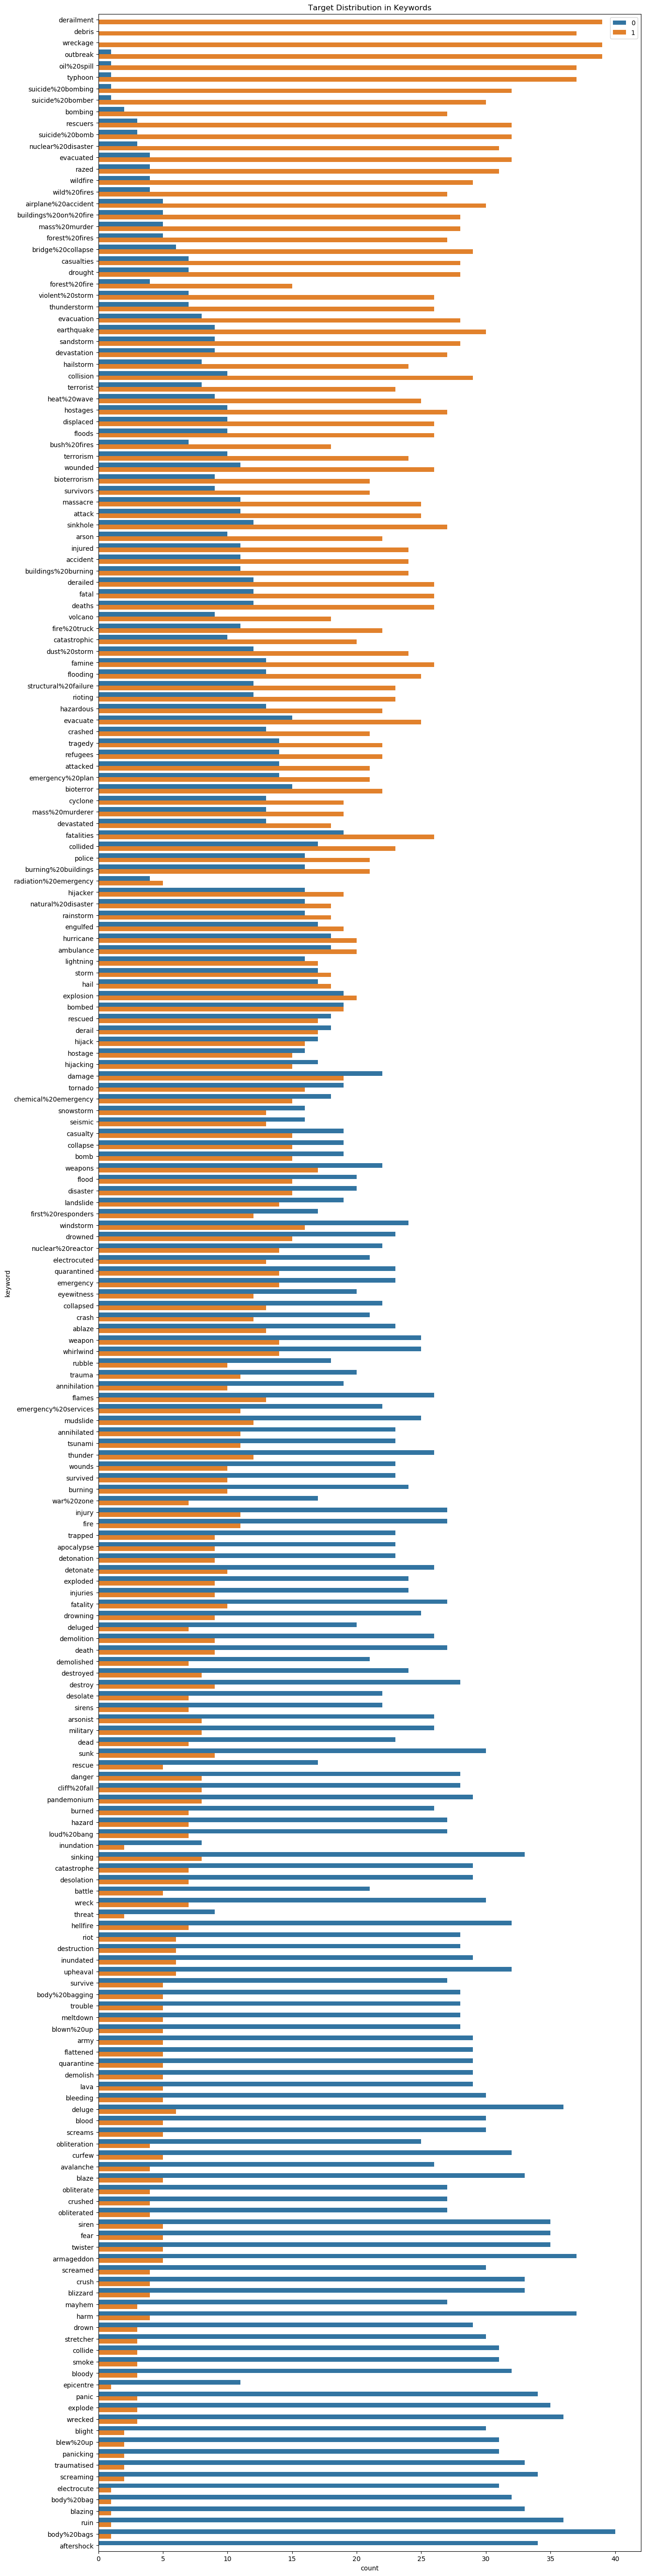

In [49]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(15, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='target_mean', ascending=True)['target'])

#plt.tick_params(axis='x',labelsize=15)
#plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

## 1-3 ) Exploratory Data Analysis of Tweets

In [50]:
# number of characters
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# number of words
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# average word length of each tweet
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# number of stop words
stop_words = set(stopwords.words('english')) 
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# number of hashtag
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# number of mention
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

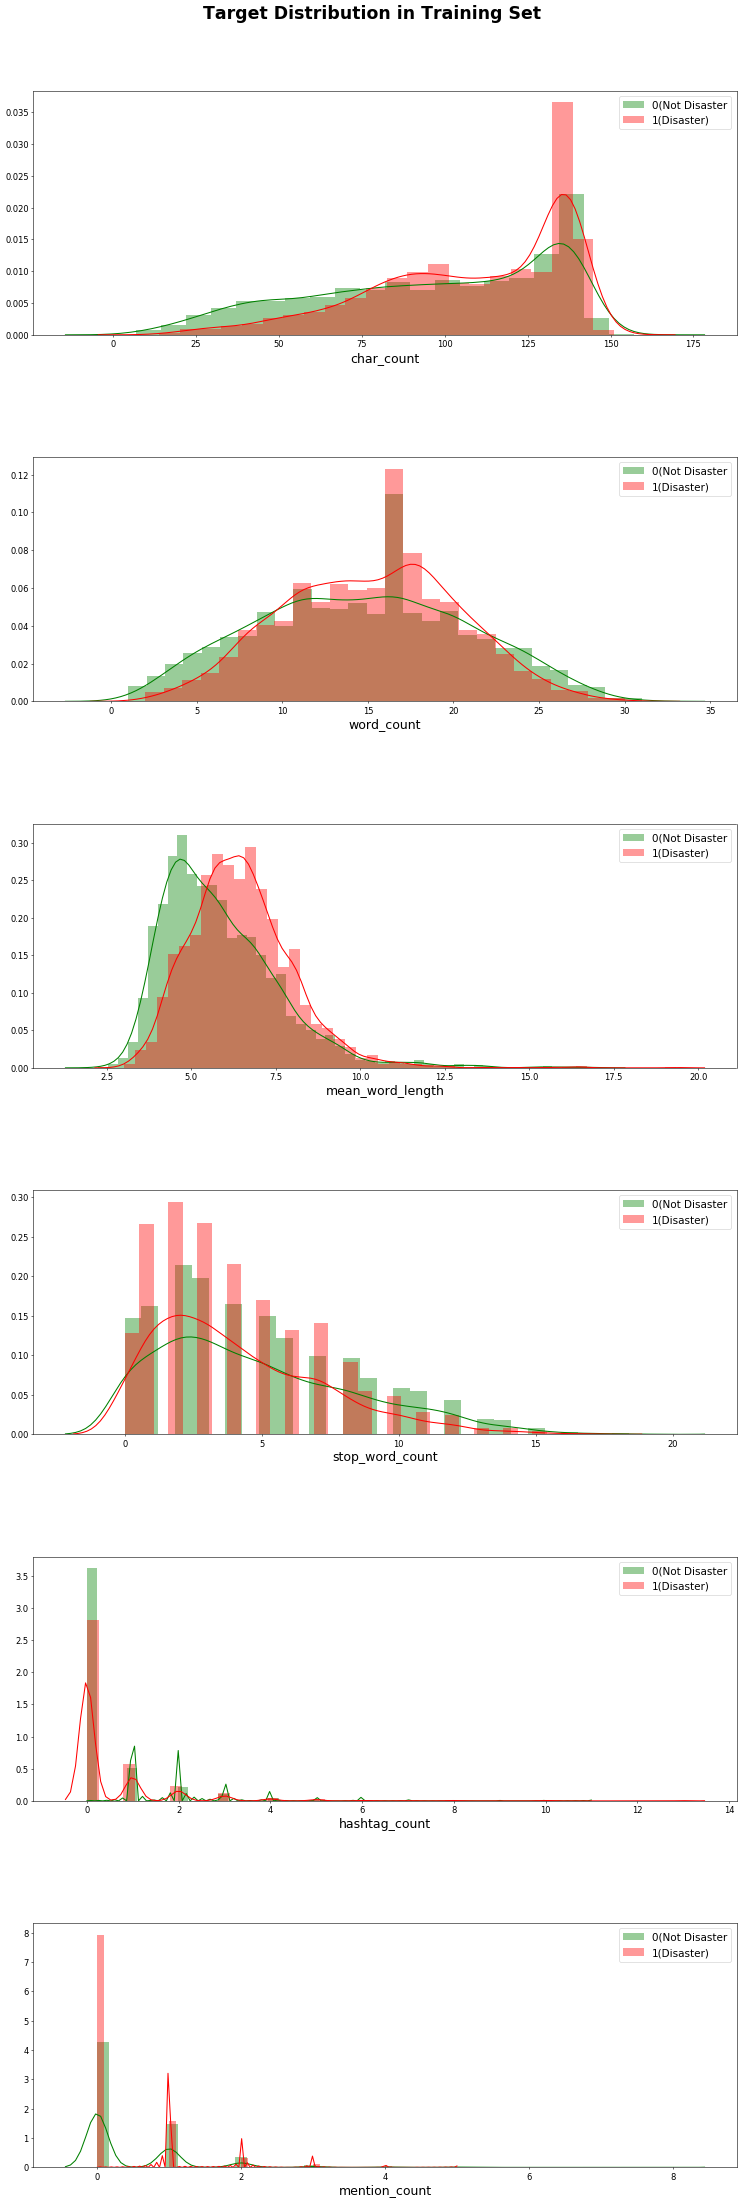

In [51]:
METAFEATURES = ['char_count', 'word_count', 'mean_word_length'
                , 'stop_word_count','hashtag_count', 'mention_count']
DISASTER_TWEETS = train_df['target'] == 1


fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(15, 50), dpi=50)


for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='0(Not Disaster', ax=axes[i], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='1(Disaster)', ax=axes[i], color='red')
    axes[i].legend(bbox_to_anchor=(0, 3))
    
    axes[i].set_xlabel(feature,fontsize=18)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend(fontsize=15)
    
fig.suptitle('Target Distribution in Training Set',fontsize=25, fontweight='bold')   
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(hspace = 0.5)
plt.show()

We can see that disaster tweets has  

1) more characters,  
2) longer average word length,  
3) less stop words  
4) and less mentions(@).

## 1-4) WordCloud

In [52]:
# disastaer vector

cv = feature_extraction.text.CountVectorizer(stop_words='english')
disaster_vec = cv.fit_transform(train_df.loc[DISASTER_TWEETS]['text'])
words = cv.get_feature_names()

count_mat = disaster_vec.sum(axis=0)
count = np.squeeze(np.asarray(count_mat))
count.shape
dis_word_count = list(zip(words,count))

dis_word_count = sorted(dis_word_count, key=lambda x:x[1],reverse=True)
dis_word_count[:10]

[('http', 2382),
 ('û_', 172),
 ('news', 140),
 ('amp', 135),
 ('https', 134),
 ('disaster', 121),
 ('california', 115),
 ('suicide', 112),
 ('police', 109),
 ('people', 105)]

In [53]:
# non-disastaer vector

cv = feature_extraction.text.CountVectorizer(stop_words='english')
non_dis_vec = cv.fit_transform(train_df.loc[~DISASTER_TWEETS]['text'])

words = cv.get_feature_names()
non_dis_count_mat = non_dis_vec.sum(axis=0)

non_dis_count = np.squeeze(np.asarray(non_dis_count_mat))

non_dis_word_count = list(zip(words,non_dis_count))  # transform to tuple (word,count)
non_dis_word_count = sorted(non_dis_word_count, key=lambda x:x[1],reverse=True)
non_dis_word_count[:10]

[('http', 1927),
 ('https', 277),
 ('like', 254),
 ('just', 234),
 ('amp', 209),
 ('û_', 176),
 ('new', 170),
 ('don', 138),
 ('body', 116),
 ('video', 96)]

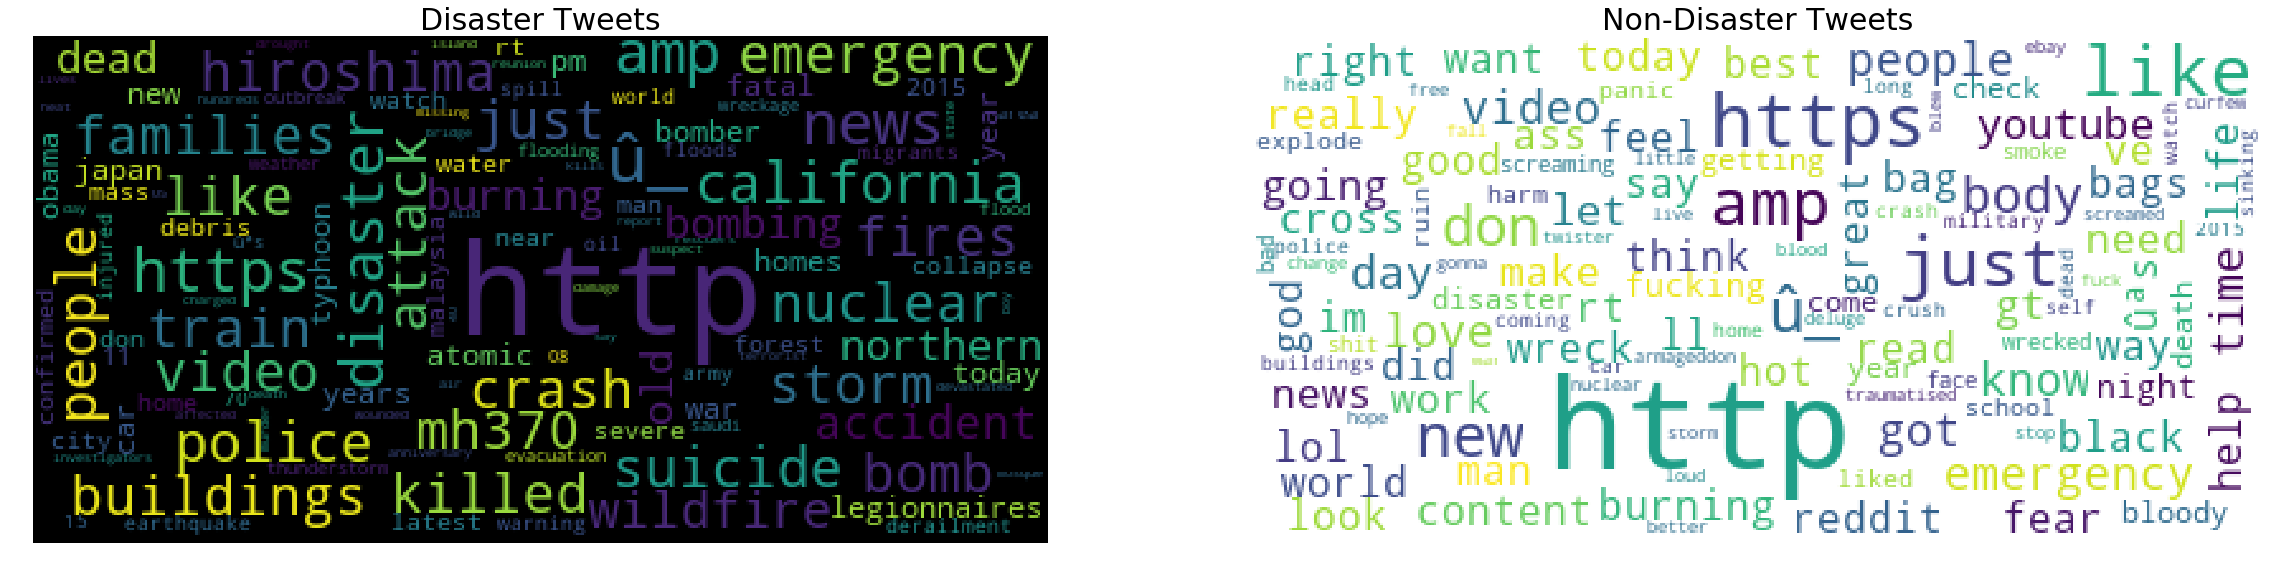

In [54]:
plt.figure(figsize=(40, 40))

plt.subplot(1,2,1).set_title("Disaster Tweets",fontsize=30)
dis_wc = WordCloud(max_font_size=50, max_words=120,background_color='Black')
dis_cloud = dis_wc.generate_from_frequencies(dict(dis_word_count))
plt.imshow(dis_cloud)
plt.axis('off')

plt.subplot(1,2,2).set_title("Non-Disaster Tweets",fontsize=30)
non_dis_wc = WordCloud(max_font_size=50, max_words=120,background_color='White')
non_dis_cloud = non_dis_wc.generate_from_frequencies(dict(non_dis_word_count))
plt.imshow(non_dis_cloud)
plt.axis('off')

plt.show()

It seems there are still useless words like 'http', 'https', or 'û_'.  
However we can see disaster tweets have more disaster related words like 'fires', 'killed', 'hiroshima' or 'nuclear'.

## 2) Preprocessing

## 2-1) Cleaning

Before modeling, we should clean text in both train and test data by removing punctuations, urls, emojis since they don't give much information about target.

In [55]:
text = pd.concat([train_df,test_df])

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,char_count,hashtag_count,id,keyword,location,mean_word_length,mention_count,stop_word_count,target,target_mean,text,word_count
0,69,1,1,NaN,NaN,4.384615,0,6,1.0,NaN,Our Deeds are the Reason of this #earthquake M...,13
1,38,0,4,NaN,NaN,4.571429,0,0,1.0,NaN,Forest fire near La Ronge Sask. Canada,7
2,133,0,5,NaN,NaN,5.090909,0,11,1.0,NaN,All residents asked to 'shelter in place' are ...,22
3,65,1,6,NaN,NaN,7.125000,0,1,1.0,NaN,"13,000 people receive #wildfires evacuation or...",8
4,88,2,7,NaN,NaN,4.500000,0,7,1.0,NaN,Just got sent this photo from Ruby #Alaska as ...,16
...,...,...,...,...,...,...,...,...,...,...,...,...
3258,55,0,10861,NaN,NaN,6.000000,0,0,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,8
3259,139,0,10865,NaN,NaN,5.086957,0,6,NaN,NaN,Storm in RI worse than last hurricane. My city...,23
3260,55,0,10868,NaN,NaN,8.333333,0,1,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,6
3261,65,0,10874,NaN,NaN,8.428571,0,0,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,7


## 3) Modeling

## 3-1) CountVectorize

In [ ]:
count_vectorizer = feature_extraction.text.CountVectorizer(stop_words='english')

train_vectors = count_vectorizer.fit_transform(train_df["text"])

# 학습데이터에서 설정된 변환을 위한 기반 설정을 그대로 테스트 데이터에 적용
# 학습할 때와 동일한 기반설정으로 동일하게 테스트 데이터를 변환
test_vectors = count_vectorizer.transform(test_df["text"])

In [ ]:
# text : 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
train_vectors[0]

Let's start from assuming that count-vector and target value(0 or 1) have linear connection. For testing on the trining data, I'll use cross-validation and the metric will be F1 score, which this competition is asking for.

In [ ]:
ln_clf = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(ln_clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

+) TFIDF, LSA, LSTM, RNNs, ngram ,...

In [ ]:
ln_clf.fit(train_vectors, train_df['target'])

In [ ]:
count_vectorizer2 = feature_extraction.text.CountVectorizer(stop_words = 'english')
count_vectorizer2.fit_transform(train_df['text'])
test_vectors = count_vectorizer.transform(test_df["text"])

In [ ]:
count_vectorizer2.vocabulary_

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
train_tfidf_vec = TfidfVectorizer().fit_transform(train_df['text'])
test_tfidf_vec = TfidfVectorizer().fit(test_df['text'])

In [ ]:
train_tfidf_vec

## submission example

In [ ]:
mysample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [ ]:
mysample_submission["target"] = ln_clf.predict(test_vectors)

mysample_submission.head()

In [ ]:
mysample_submission.to_csv("mysubmission.csv", index=False)